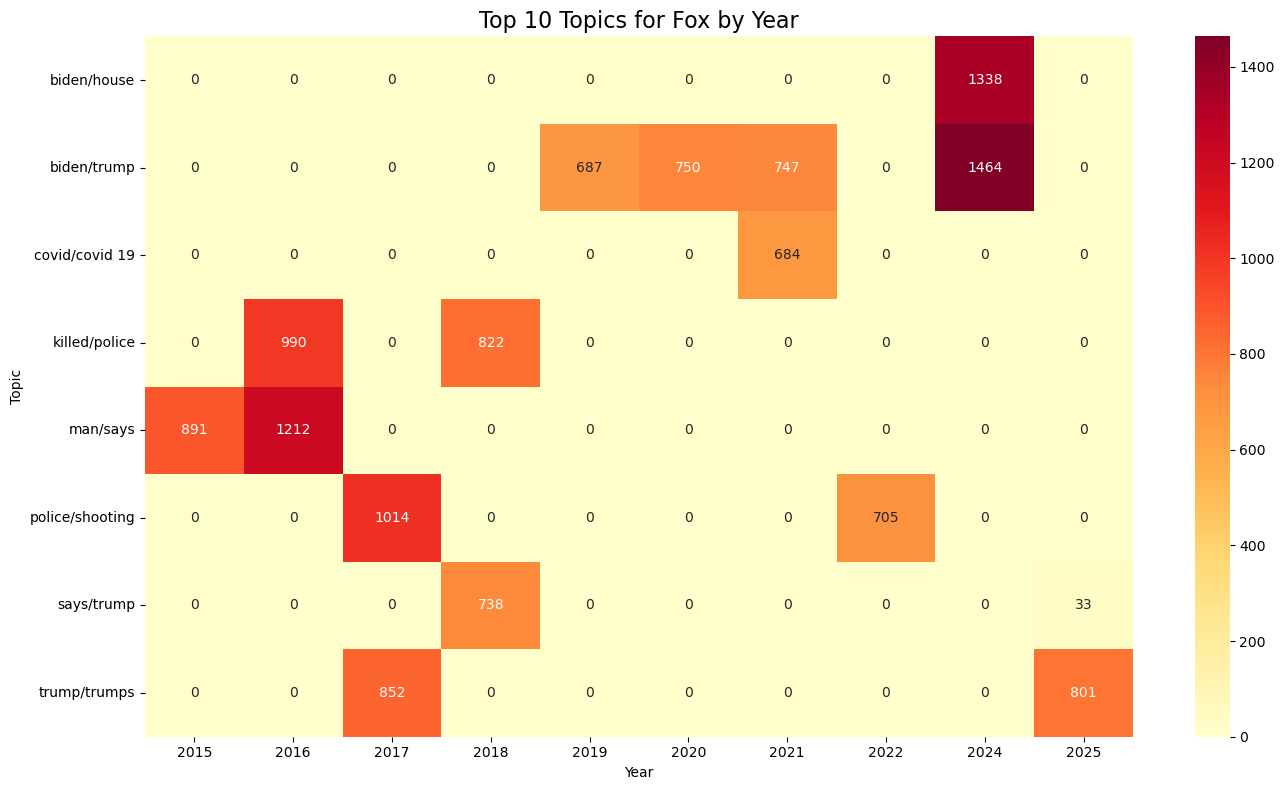

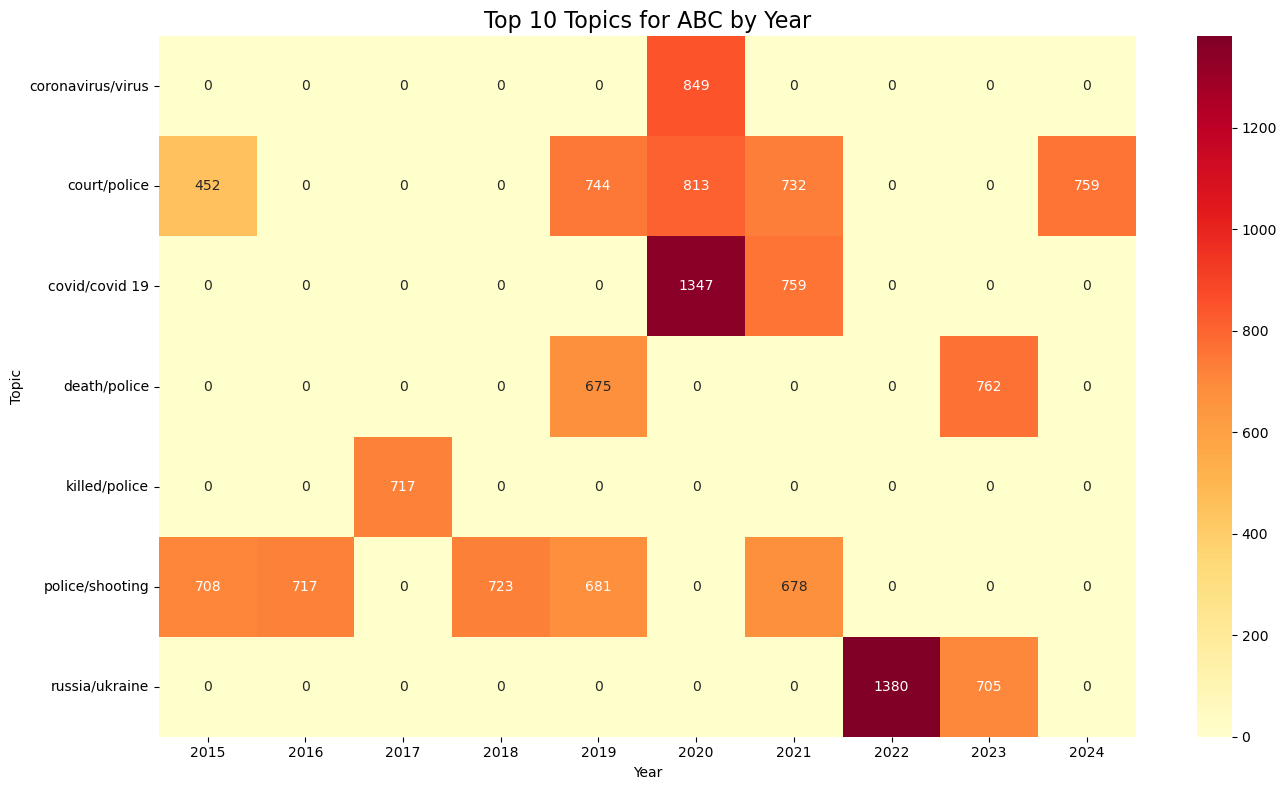

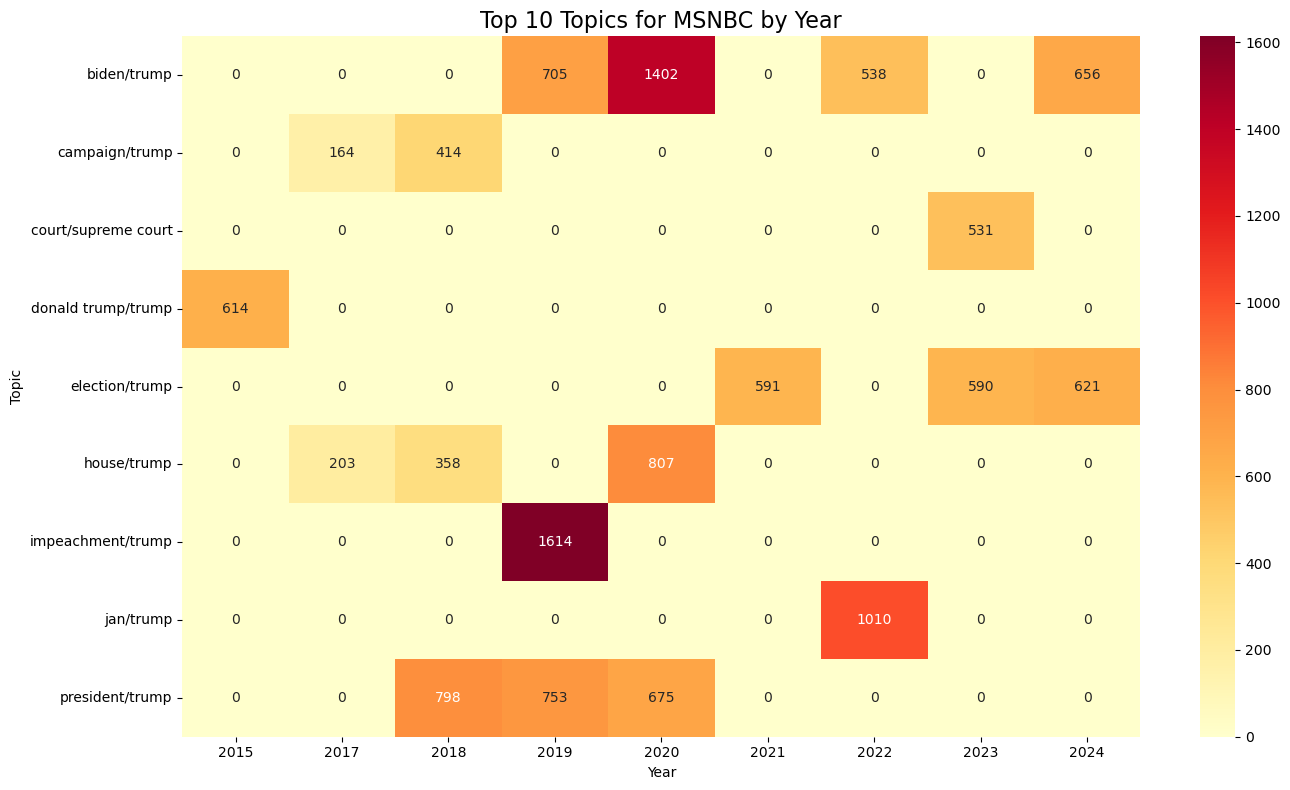

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
fox_data = pd.read_csv('../data/topic_modeling/fox_headline_topics_sklearn.csv')
abc_data = pd.read_csv('../data/topic_modeling/abc_headline_topics_sklearn.csv')
msnbc_data = pd.read_csv('../data/topic_modeling/msnbc_headline_topics_sklearn.csv')

# Add source column to each dataset
fox_data['source'] = 'Fox'
abc_data['source'] = 'ABC'
msnbc_data['source'] = 'MSNBC'

# Combine datasets
combined_data = pd.concat([fox_data, abc_data, msnbc_data], ignore_index=True)

# Function to create a topic trends visualization
def plot_topic_trends(data, news_source, top_n=10):
    # Get top topics by total count
    topic_counts = data[data['source'] == news_source].groupby('topic')['count'].sum().nlargest(top_n)
    top_topics = topic_counts.index.tolist()
    
    # Filter for only top topics and rank 1
    filtered_data = data[(data['source'] == news_source) & 
                         (data['topic'].isin(top_topics)) &
                         (data['rank'] == 1)]
    
    # Group by year and topic, calculate the sum of counts
    yearly_topic_counts = filtered_data.groupby(['year', 'topic'])['count'].sum().reset_index()
    
    # Pivot for heatmap format
    pivot_data = yearly_topic_counts.pivot(index='topic', columns='year', values='count').fillna(0)
    
    # Plot
    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.0f')
    plt.title(f'Top {top_n} Topics for {news_source} by Year', fontsize=16)
    plt.ylabel('Topic')
    plt.xlabel('Year')
    plt.tight_layout()
    plt.savefig(f'{news_source.lower()}_topic_trends.png', dpi=300)
    plt.show()

# Create trend plots for each source
plot_topic_trends(combined_data, 'Fox')
plot_topic_trends(combined_data, 'ABC')
plot_topic_trends(combined_data, 'MSNBC')

<Figure size 1400x1000 with 0 Axes>

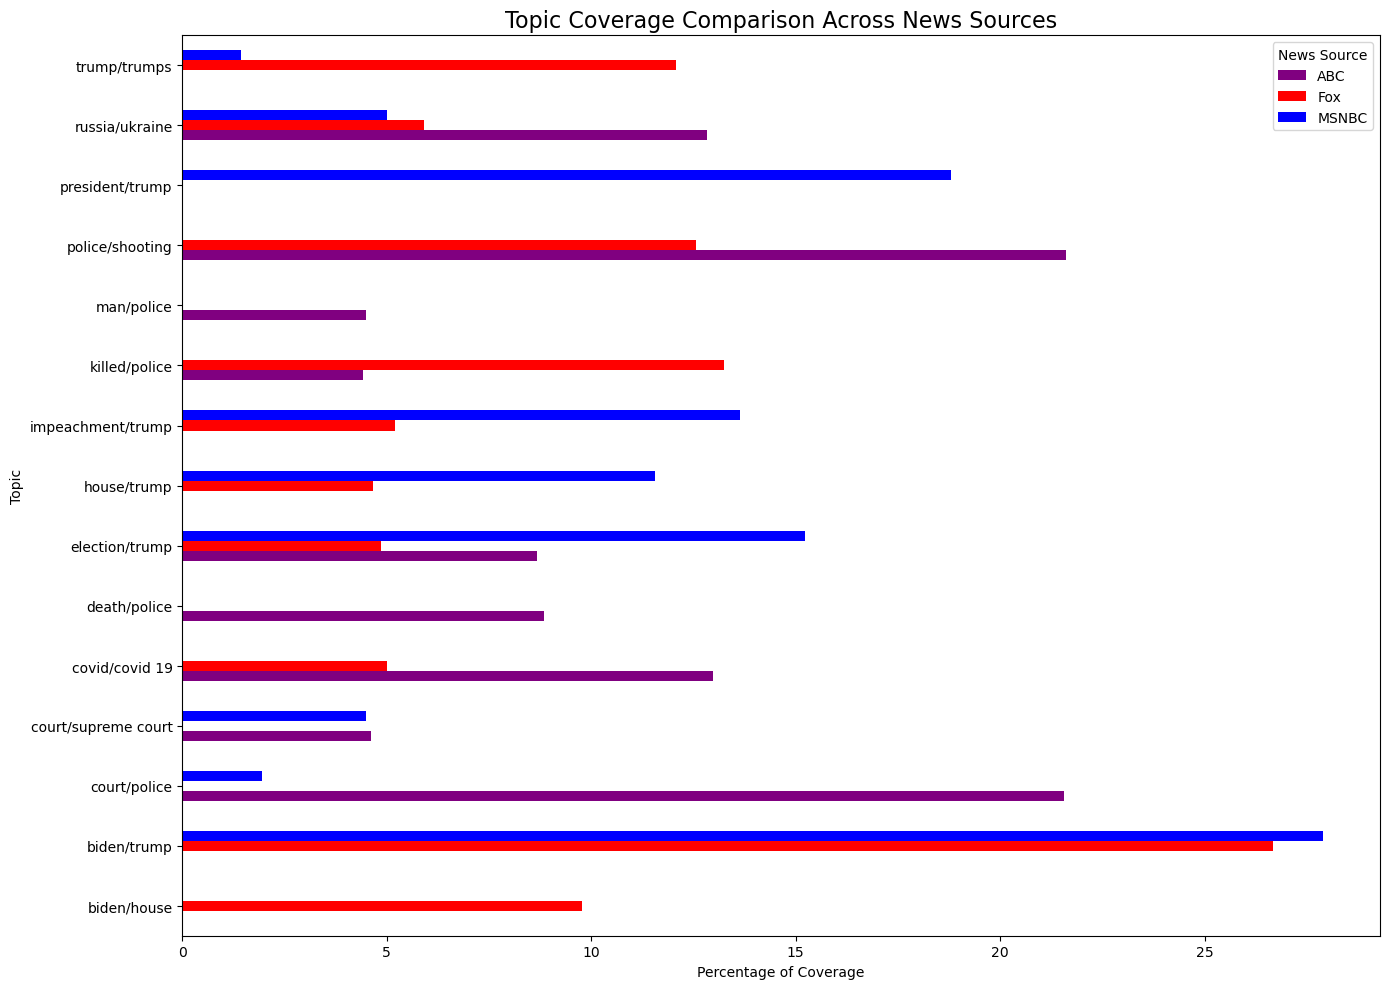

In [8]:
def compare_topics_across_sources(data, top_n=15):
    # Get top topics overall
    top_topics = data.groupby('topic')['count'].sum().nlargest(top_n).index.tolist()
    
    # Filter for only top topics and rank 1
    filtered_data = data[(data['topic'].isin(top_topics)) & (data['rank'] == 1)]
    
    # Calculate percentage of coverage by source
    source_topic_counts = filtered_data.groupby(['source', 'topic'])['count'].sum().reset_index()
    source_counts = filtered_data.groupby('source')['count'].sum().reset_index()
    source_counts.columns = ['source', 'total_count']
    
    # Merge to get percentages
    source_topic_percentages = pd.merge(source_topic_counts, source_counts, on='source')
    source_topic_percentages['percentage'] = (source_topic_percentages['count'] / 
                                             source_topic_percentages['total_count']) * 100
    
    # Pivot for barplot
    pivot_data = source_topic_percentages.pivot(index='topic', columns='source', values='percentage').fillna(0)
    
    # Create custom color map for the news sources
    color_map = {'MSNBC': 'blue', 'Fox': 'red', 'ABC': 'purple'}
    
    # Plot
    plt.figure(figsize=(14, 10))
    pivot_data.plot(kind='barh', figsize=(14, 10), color=[color_map.get(x, 'gray') for x in pivot_data.columns])
    plt.title('Topic Coverage Comparison Across News Sources', fontsize=16)
    plt.xlabel('Percentage of Coverage')
    plt.ylabel('Topic')
    plt.legend(title='News Source')
    plt.tight_layout()
    plt.savefig('topic_comparison_across_sources.png', dpi=300)
    plt.show()

compare_topics_across_sources(combined_data)

<Figure size 1400x1000 with 0 Axes>

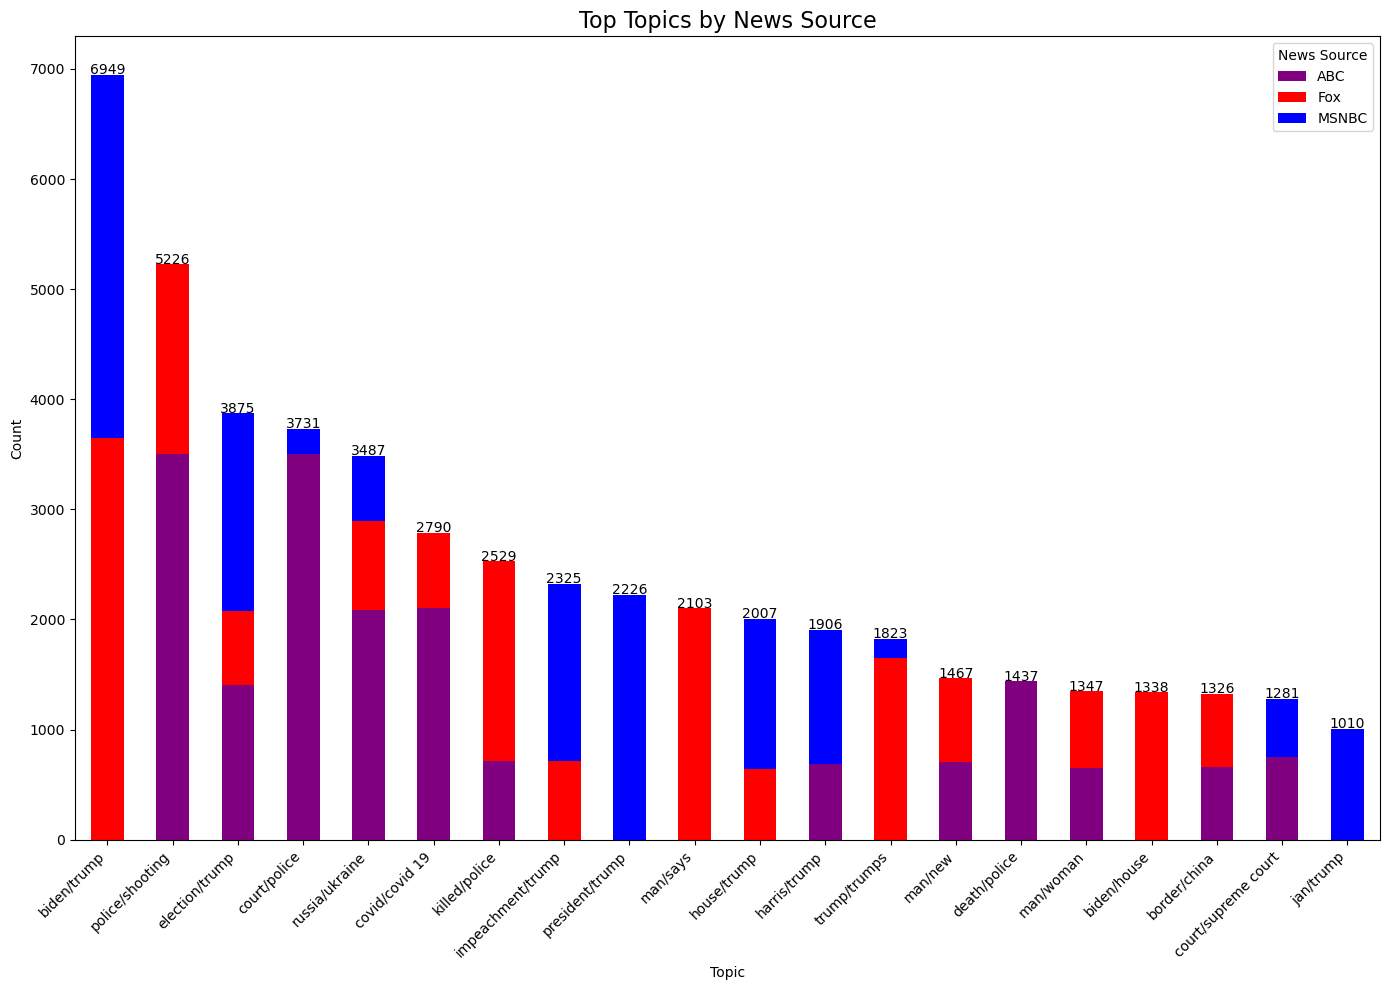

Most common topics overall with source breakdown:
biden/trump: 6949 (Fox: 3648, MSNBC: 3301)
police/shooting: 5226 (ABC: 3507, Fox: 1719)
election/trump: 3875 (ABC: 1407, Fox: 666, MSNBC: 1802)
court/police: 3731 (ABC: 3500, MSNBC: 231)
russia/ukraine: 3487 (ABC: 2085, Fox: 810, MSNBC: 592)
covid/covid 19: 2790 (ABC: 2106, Fox: 684)
killed/police: 2529 (ABC: 717, Fox: 1812)
impeachment/trump: 2325 (Fox: 711, MSNBC: 1614)
president/trump: 2226 (MSNBC: 2226)
man/says: 2103 (Fox: 2103)
house/trump: 2007 (Fox: 639, MSNBC: 1368)
harris/trump: 1906 (ABC: 684, MSNBC: 1222)
trump/trumps: 1823 (Fox: 1653, MSNBC: 170)
man/new: 1467 (ABC: 705, Fox: 762)
death/police: 1437 (ABC: 1437)
man/woman: 1347 (ABC: 648, Fox: 699)
biden/house: 1338 (Fox: 1338)
border/china: 1326 (ABC: 660, Fox: 666)
court/supreme court: 1281 (ABC: 750, MSNBC: 531)
jan/trump: 1010 (MSNBC: 1010)


In [9]:
def analyze_top_topics_overall(data, top_n=20):
    # Filter for rank 1 topics (most important for each month)
    rank1_data = data[data['rank'] == 1]
    
    # Get top topics by frequency across all sources
    top_topics_overall = rank1_data.groupby('topic')['count'].sum().nlargest(top_n).index.tolist()
    
    # Filter data for just these topics
    filtered_data = rank1_data[rank1_data['topic'].isin(top_topics_overall)]
    
    # Group by topic and source to get the breakdown
    source_topic_counts = filtered_data.groupby(['topic', 'source'])['count'].sum().reset_index()
    
    # Pivot the data for stacked bar chart
    pivot_data = source_topic_counts.pivot(index='topic', columns='source', values='count').fillna(0)
    
    # Reorder rows by total count
    total_counts = pivot_data.sum(axis=1)
    pivot_data = pivot_data.loc[total_counts.sort_values(ascending=False).index]
    
    # Create custom color map for the news sources
    color_map = {'MSNBC': 'blue', 'Fox': 'red', 'ABC': 'purple'}
    
    # Create a stacked bar chart
    plt.figure(figsize=(14, 10))
    ax = pivot_data.plot(
        kind='bar', 
        stacked=True, 
        figsize=(14, 10), 
        color=[color_map.get(x, 'gray') for x in pivot_data.columns]
    )
    
    plt.title('Top Topics by News Source', fontsize=16)
    plt.xlabel('Topic')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='News Source')
    
    # Add total count labels on top of each stacked bar
    for i, total in enumerate(pivot_data.sum(axis=1)):
        ax.text(i, total + 5, str(int(total)), ha='center')
    
    plt.tight_layout()
    plt.savefig('top_topics_by_source.png', dpi=300)
    plt.show()
    
    # Print the breakdown
    print("Most common topics overall with source breakdown:")
    for topic in pivot_data.index:
        total = pivot_data.loc[topic].sum()
        sources = ", ".join([f"{source}: {int(count)}" for source, count in pivot_data.loc[topic].items() if count > 0])
        print(f"{topic}: {int(total)} ({sources})")
    
    # Return the pivot data for further analysis
    return pivot_data

top_topics_by_source = analyze_top_topics_overall(combined_data)

<Figure size 1400x800 with 0 Axes>

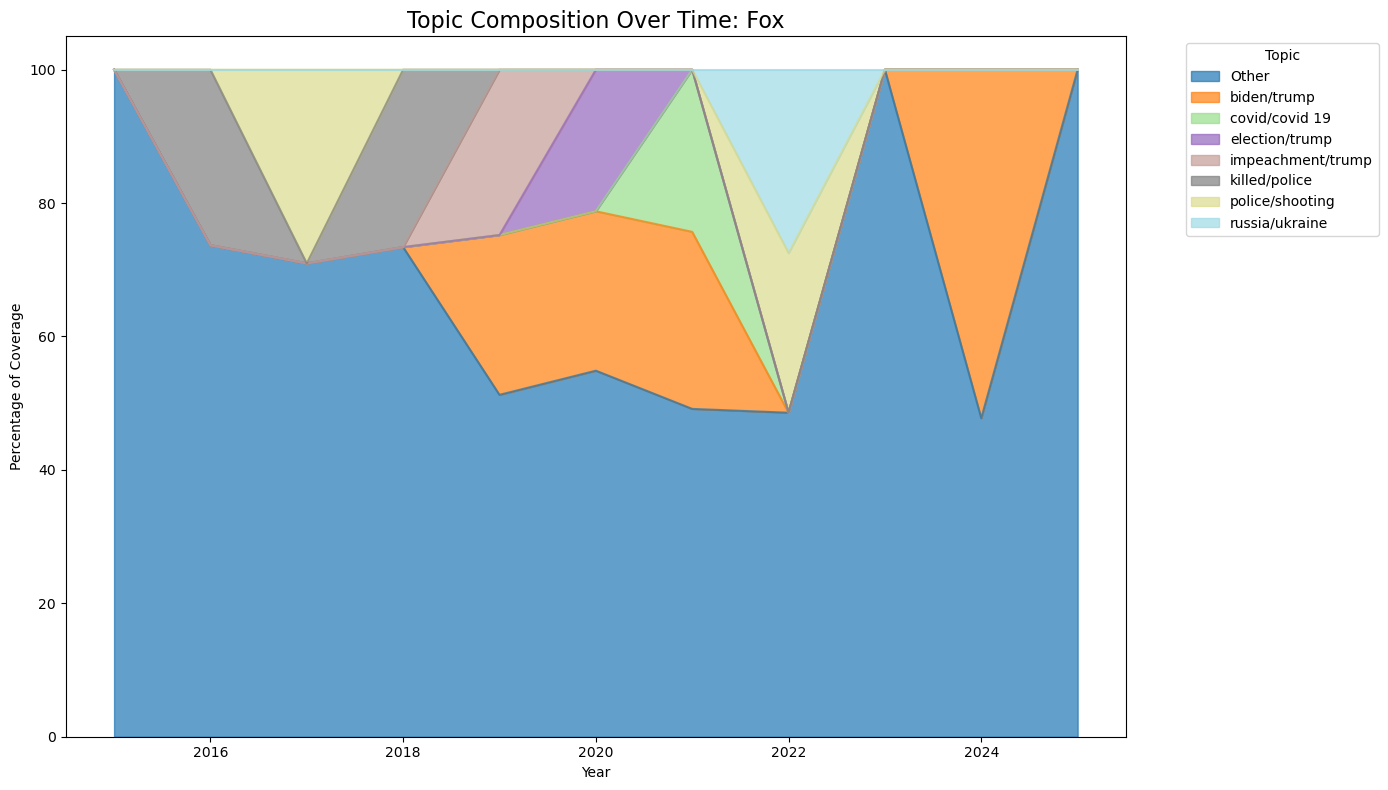

<Figure size 1400x800 with 0 Axes>

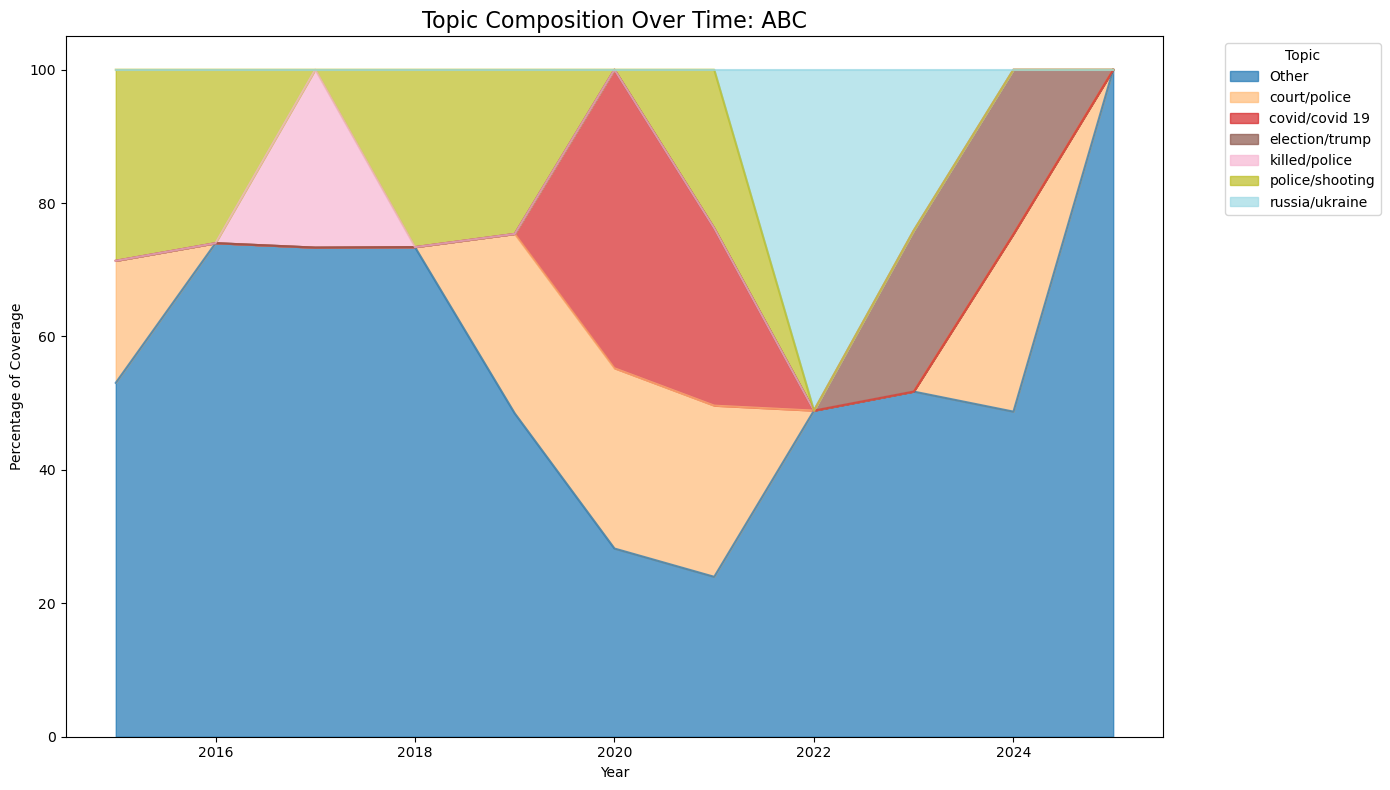

<Figure size 1400x800 with 0 Axes>

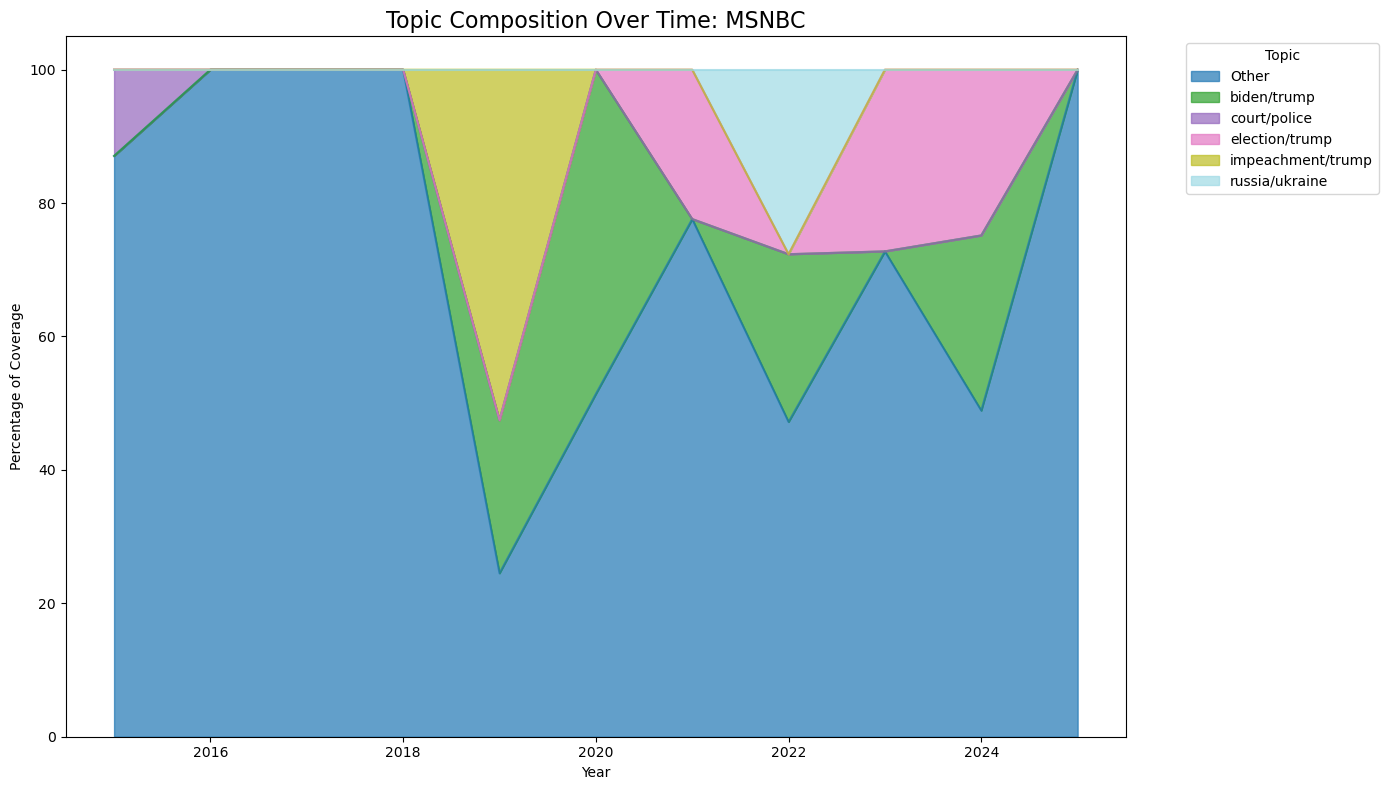

In [5]:
def plot_topic_composition_over_time(data, top_n=8):
    # Get top topics overall
    top_topics = data[data['rank'] == 1].groupby('topic')['count'].sum().nlargest(top_n).index.tolist()
    
    # Create "Other" category for remaining topics
    data = data.copy()
    data.loc[~data['topic'].isin(top_topics) & (data['rank'] == 1), 'topic'] = 'Other'
    
    # Group by source, year and topic
    yearly_composition = data[data['rank'] == 1].groupby(['source', 'year', 'topic'])['count'].sum().reset_index()
    
    # Create separate plot for each source
    for source in data['source'].unique():
        source_data = yearly_composition[yearly_composition['source'] == source]
        
        # Pivot to get topics as columns
        pivot_data = source_data.pivot(index='year', columns='topic', values='count').fillna(0)
        
        # Normalize to percentage
        pivot_data = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
        
        # Plot
        plt.figure(figsize=(14, 8))
        pivot_data.plot.area(stacked=True, alpha=0.7, figsize=(14, 8), colormap='tab20')
        plt.title(f'Topic Composition Over Time: {source}', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel('Percentage of Coverage')
        plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{source.lower()}_topic_composition.png', dpi=300)
        plt.show()

plot_topic_composition_over_time(combined_data)